In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
train_dir = 'C://Users//pauls//Desktop//Dataset_tumor//Train'
test_dir = 'C://Users//pauls//Desktop//Dataset_tumor//Test'

extracted_features_dir = 'C://Users//pauls//Desktop//extracted_features//'
model_name = "Macenko_Xception_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_data_format)

Keras Version 2.5.0
tensorflow Version 2.5.0-rc0
dim_ordering: <function image_data_format at 0x0000020C44D7FC10>


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

C://Users//pauls//Desktop//Dataset_tumor//Train 0
C://Users//pauls//Desktop//Dataset_tumor//Train\benign 6128
C://Users//pauls//Desktop//Dataset_tumor//Train\malignant 2976
******************************
C://Users//pauls//Desktop//Dataset_tumor//Test 0
C://Users//pauls//Desktop//Dataset_tumor//Test\benign 126
C://Users//pauls//Desktop//Dataset_tumor//Test\malignant 51


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 6828 images belonging to 2 classes.
Found 2276 images belonging to 2 classes.
Found 177 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 6828
nb_validation_samples: 2276

predict_size_train: 214
predict_size_validation: 72
nb_test_samples: 177
predict_size_test: 6

 num_classes: 2


In [9]:
from keras.backend import get_session
from keras.backend import clear_session
from keras.backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.compat.v1.Session(config=config))


reset_keras_tf_session()

In [10]:
model = Xception(weights='imagenet', include_top=False, pooling = 'avg',input_tensor=Input(shape=input_shape))

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [12]:
c1 = model.layers[16].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[26].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[36].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[126].output
c4 = GlobalAveragePooling2D()(c4) 

con = concatenate([c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam = Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpca8p7n5k.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpca8p7n5k.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
214/214 - 19s - loss: 0.4881 - accuracy: 0.7907 - val_loss: 0.3689 - val_accuracy: 0.8445
Epoch 2/1000
214/214 - 1s - loss: 0.3552 - accuracy: 0.8467 - val_loss: 0.3135 - val_accuracy: 0.8695
Epoch 3/1000
214/214 - 1s - loss: 0.3264 - accuracy: 0.8569 - val_loss: 0.2817 - val_accuracy: 0.8761
Epoch 4/1000
214/214 - 1s - loss: 0.2972 - accuracy: 0.8754 - val_loss: 0.2635 - val_accu

Epoch 72/1000
214/214 - 1s - loss: 0.1183 - accuracy: 0.9467 - val_loss: 0.0855 - val_accuracy: 0.9701
Epoch 73/1000
214/214 - 1s - loss: 0.1231 - accuracy: 0.9438 - val_loss: 0.0947 - val_accuracy: 0.9622
Epoch 74/1000
214/214 - 1s - loss: 0.1199 - accuracy: 0.9408 - val_loss: 0.0716 - val_accuracy: 0.9692
Epoch 75/1000
214/214 - 1s - loss: 0.1243 - accuracy: 0.9401 - val_loss: 0.0834 - val_accuracy: 0.9675
Epoch 76/1000
214/214 - 1s - loss: 0.1284 - accuracy: 0.9386 - val_loss: 0.0759 - val_accuracy: 0.9662
Epoch 77/1000
214/214 - 1s - loss: 0.1407 - accuracy: 0.9278 - val_loss: 0.1137 - val_accuracy: 0.9534
Epoch 78/1000
214/214 - 1s - loss: 0.1241 - accuracy: 0.9417 - val_loss: 0.0985 - val_accuracy: 0.9666
Epoch 79/1000
214/214 - 1s - loss: 0.1149 - accuracy: 0.9413 - val_loss: 0.0889 - val_accuracy: 0.9662
Epoch 80/1000
214/214 - 1s - loss: 0.1097 - accuracy: 0.9458 - val_loss: 0.0810 - val_accuracy: 0.9679
Epoch 81/1000
214/214 - 1s - loss: 0.1142 - accuracy: 0.9405 - val_loss: 

214/214 - 1s - loss: 0.1030 - accuracy: 0.9480 - val_loss: 0.0712 - val_accuracy: 0.9697
Epoch 152/1000
214/214 - 1s - loss: 0.0975 - accuracy: 0.9527 - val_loss: 0.0714 - val_accuracy: 0.9763
Epoch 153/1000
214/214 - 1s - loss: 0.0856 - accuracy: 0.9572 - val_loss: 0.0598 - val_accuracy: 0.9785
Epoch 154/1000
214/214 - 1s - loss: 0.0899 - accuracy: 0.9547 - val_loss: 0.0643 - val_accuracy: 0.9758
Epoch 155/1000
214/214 - 1s - loss: 0.0778 - accuracy: 0.9591 - val_loss: 0.0711 - val_accuracy: 0.9772
Epoch 156/1000
214/214 - 1s - loss: 0.1048 - accuracy: 0.9504 - val_loss: 0.0695 - val_accuracy: 0.9772
Epoch 157/1000
214/214 - 1s - loss: 0.0840 - accuracy: 0.9564 - val_loss: 0.0756 - val_accuracy: 0.9780
Epoch 158/1000
214/214 - 1s - loss: 0.0892 - accuracy: 0.9524 - val_loss: 0.0808 - val_accuracy: 0.9701
Epoch 159/1000
214/214 - 1s - loss: 0.0830 - accuracy: 0.9552 - val_loss: 0.0559 - val_accuracy: 0.9820
Epoch 160/1000
214/214 - 1s - loss: 0.0846 - accuracy: 0.9565 - val_loss: 0.068

Epoch 230/1000
214/214 - 1s - loss: 0.0689 - accuracy: 0.9606 - val_loss: 0.0786 - val_accuracy: 0.9754
Epoch 231/1000
214/214 - 1s - loss: 0.0734 - accuracy: 0.9625 - val_loss: 0.0766 - val_accuracy: 0.9789
Epoch 232/1000
214/214 - 1s - loss: 0.0771 - accuracy: 0.9559 - val_loss: 0.0686 - val_accuracy: 0.9785
Epoch 233/1000
214/214 - 1s - loss: 0.0758 - accuracy: 0.9580 - val_loss: 0.0640 - val_accuracy: 0.9767
Epoch 234/1000
214/214 - 1s - loss: 0.0780 - accuracy: 0.9619 - val_loss: 0.0694 - val_accuracy: 0.9776
Epoch 235/1000
214/214 - 1s - loss: 0.0769 - accuracy: 0.9565 - val_loss: 0.0768 - val_accuracy: 0.9754
Epoch 236/1000
214/214 - 1s - loss: 0.0846 - accuracy: 0.9531 - val_loss: 0.0676 - val_accuracy: 0.9789
Epoch 237/1000
214/214 - 1s - loss: 0.0707 - accuracy: 0.9597 - val_loss: 0.0668 - val_accuracy: 0.9780
Epoch 238/1000
214/214 - 1s - loss: 0.0738 - accuracy: 0.9609 - val_loss: 0.0786 - val_accuracy: 0.9732
Epoch 239/1000
214/214 - 1s - loss: 0.0700 - accuracy: 0.9619 - 

Epoch 309/1000
214/214 - 1s - loss: 0.0636 - accuracy: 0.9670 - val_loss: 0.0911 - val_accuracy: 0.9772
Epoch 310/1000
214/214 - 1s - loss: 0.0615 - accuracy: 0.9662 - val_loss: 0.0657 - val_accuracy: 0.9793
Epoch 311/1000
214/214 - 1s - loss: 0.0733 - accuracy: 0.9631 - val_loss: 0.0701 - val_accuracy: 0.9780
Epoch 312/1000
214/214 - 1s - loss: 0.0710 - accuracy: 0.9631 - val_loss: 0.0788 - val_accuracy: 0.9745
Epoch 313/1000
214/214 - 1s - loss: 0.0770 - accuracy: 0.9646 - val_loss: 0.0790 - val_accuracy: 0.9776
Epoch 314/1000
214/214 - 1s - loss: 0.0710 - accuracy: 0.9646 - val_loss: 0.0740 - val_accuracy: 0.9754
Epoch 315/1000
214/214 - 1s - loss: 0.0757 - accuracy: 0.9631 - val_loss: 0.0777 - val_accuracy: 0.9763
Epoch 316/1000
214/214 - 1s - loss: 0.0633 - accuracy: 0.9679 - val_loss: 0.0672 - val_accuracy: 0.9811
Epoch 317/1000
214/214 - 1s - loss: 0.0635 - accuracy: 0.9668 - val_loss: 0.0688 - val_accuracy: 0.9763
Epoch 318/1000
214/214 - 1s - loss: 0.0641 - accuracy: 0.9665 - 

Epoch 388/1000
214/214 - 1s - loss: 0.0635 - accuracy: 0.9613 - val_loss: 0.0592 - val_accuracy: 0.9780
Epoch 389/1000
214/214 - 1s - loss: 0.0691 - accuracy: 0.9657 - val_loss: 0.0512 - val_accuracy: 0.9802
Epoch 390/1000
214/214 - 1s - loss: 0.0581 - accuracy: 0.9694 - val_loss: 0.0647 - val_accuracy: 0.9811
Epoch 391/1000
214/214 - 1s - loss: 0.0559 - accuracy: 0.9732 - val_loss: 0.0598 - val_accuracy: 0.9829
Epoch 392/1000
214/214 - 1s - loss: 0.0556 - accuracy: 0.9707 - val_loss: 0.0584 - val_accuracy: 0.9807
Epoch 393/1000
214/214 - 1s - loss: 0.0547 - accuracy: 0.9720 - val_loss: 0.0650 - val_accuracy: 0.9807
Epoch 394/1000
214/214 - 1s - loss: 0.0608 - accuracy: 0.9697 - val_loss: 0.0761 - val_accuracy: 0.9785
Epoch 395/1000
214/214 - 1s - loss: 0.0644 - accuracy: 0.9662 - val_loss: 0.0693 - val_accuracy: 0.9807
Epoch 396/1000
214/214 - 1s - loss: 0.0609 - accuracy: 0.9690 - val_loss: 0.0649 - val_accuracy: 0.9802
Epoch 397/1000
214/214 - 1s - loss: 0.0562 - accuracy: 0.9707 - 

Epoch 467/1000
214/214 - 1s - loss: 0.0658 - accuracy: 0.9651 - val_loss: 0.0785 - val_accuracy: 0.9789
Epoch 468/1000
214/214 - 1s - loss: 0.0589 - accuracy: 0.9665 - val_loss: 0.0838 - val_accuracy: 0.9780
Epoch 469/1000
214/214 - 1s - loss: 0.0532 - accuracy: 0.9731 - val_loss: 0.0710 - val_accuracy: 0.9811
Epoch 470/1000
214/214 - 1s - loss: 0.0456 - accuracy: 0.9761 - val_loss: 0.0721 - val_accuracy: 0.9807
Epoch 471/1000
214/214 - 1s - loss: 0.0557 - accuracy: 0.9714 - val_loss: 0.0615 - val_accuracy: 0.9793
Epoch 472/1000
214/214 - 1s - loss: 0.0514 - accuracy: 0.9728 - val_loss: 0.0934 - val_accuracy: 0.9767
Epoch 473/1000
214/214 - 1s - loss: 0.0501 - accuracy: 0.9745 - val_loss: 0.0627 - val_accuracy: 0.9815
Epoch 474/1000
214/214 - 1s - loss: 0.0443 - accuracy: 0.9770 - val_loss: 0.0618 - val_accuracy: 0.9815
Epoch 475/1000
214/214 - 1s - loss: 0.0551 - accuracy: 0.9707 - val_loss: 0.0619 - val_accuracy: 0.9763
Epoch 476/1000
214/214 - 1s - loss: 0.0556 - accuracy: 0.9684 - 

Epoch 546/1000
214/214 - 1s - loss: 0.0510 - accuracy: 0.9704 - val_loss: 0.0846 - val_accuracy: 0.9763
Epoch 547/1000
214/214 - 1s - loss: 0.0565 - accuracy: 0.9716 - val_loss: 0.0822 - val_accuracy: 0.9780
Epoch 548/1000
214/214 - 1s - loss: 0.0524 - accuracy: 0.9733 - val_loss: 0.0786 - val_accuracy: 0.9776
Epoch 549/1000
214/214 - 1s - loss: 0.0541 - accuracy: 0.9704 - val_loss: 0.0992 - val_accuracy: 0.9732
Epoch 550/1000
214/214 - 1s - loss: 0.0559 - accuracy: 0.9703 - val_loss: 0.0840 - val_accuracy: 0.9776
Epoch 551/1000
214/214 - 1s - loss: 0.0534 - accuracy: 0.9735 - val_loss: 0.0943 - val_accuracy: 0.9776
Epoch 552/1000
214/214 - 1s - loss: 0.0491 - accuracy: 0.9722 - val_loss: 0.0819 - val_accuracy: 0.9767
Epoch 553/1000
214/214 - 1s - loss: 0.0465 - accuracy: 0.9742 - val_loss: 0.0862 - val_accuracy: 0.9785
Epoch 554/1000
214/214 - 1s - loss: 0.0528 - accuracy: 0.9709 - val_loss: 0.0784 - val_accuracy: 0.9802
Epoch 555/1000
214/214 - 1s - loss: 0.0541 - accuracy: 0.9675 - 

Epoch 625/1000
214/214 - 1s - loss: 0.0500 - accuracy: 0.9742 - val_loss: 0.0803 - val_accuracy: 0.9758
Epoch 626/1000
214/214 - 1s - loss: 0.0484 - accuracy: 0.9750 - val_loss: 0.0674 - val_accuracy: 0.9793
Epoch 627/1000
214/214 - 1s - loss: 0.0532 - accuracy: 0.9700 - val_loss: 0.0818 - val_accuracy: 0.9772
Epoch 628/1000
214/214 - 1s - loss: 0.0489 - accuracy: 0.9758 - val_loss: 0.0759 - val_accuracy: 0.9776
Epoch 629/1000
214/214 - 1s - loss: 0.0523 - accuracy: 0.9714 - val_loss: 0.0719 - val_accuracy: 0.9789
Epoch 630/1000
214/214 - 1s - loss: 0.0503 - accuracy: 0.9697 - val_loss: 0.0719 - val_accuracy: 0.9767
Epoch 631/1000
214/214 - 1s - loss: 0.0499 - accuracy: 0.9744 - val_loss: 0.0733 - val_accuracy: 0.9811
Epoch 632/1000
214/214 - 1s - loss: 0.0580 - accuracy: 0.9710 - val_loss: 0.1030 - val_accuracy: 0.9780
Epoch 633/1000
214/214 - 1s - loss: 0.0476 - accuracy: 0.9729 - val_loss: 0.0950 - val_accuracy: 0.9793
Epoch 634/1000
214/214 - 1s - loss: 0.0524 - accuracy: 0.9725 - 

Epoch 704/1000
214/214 - 1s - loss: 0.0439 - accuracy: 0.9783 - val_loss: 0.0613 - val_accuracy: 0.9820
Epoch 705/1000
214/214 - 1s - loss: 0.0473 - accuracy: 0.9748 - val_loss: 0.0625 - val_accuracy: 0.9820
Epoch 706/1000
214/214 - 1s - loss: 0.0441 - accuracy: 0.9774 - val_loss: 0.0951 - val_accuracy: 0.9719
Epoch 707/1000
214/214 - 1s - loss: 0.0507 - accuracy: 0.9735 - val_loss: 0.0816 - val_accuracy: 0.9772
Epoch 708/1000
214/214 - 1s - loss: 0.0468 - accuracy: 0.9772 - val_loss: 0.0733 - val_accuracy: 0.9798
Epoch 709/1000
214/214 - 1s - loss: 0.0445 - accuracy: 0.9760 - val_loss: 0.0822 - val_accuracy: 0.9754
Epoch 710/1000
214/214 - 1s - loss: 0.0407 - accuracy: 0.9767 - val_loss: 0.0687 - val_accuracy: 0.9807
Epoch 711/1000
214/214 - 1s - loss: 0.0425 - accuracy: 0.9764 - val_loss: 0.0813 - val_accuracy: 0.9798
Epoch 712/1000
214/214 - 1s - loss: 0.0461 - accuracy: 0.9745 - val_loss: 0.0779 - val_accuracy: 0.9807
Epoch 713/1000
214/214 - 1s - loss: 0.0460 - accuracy: 0.9747 - 

Epoch 783/1000
214/214 - 1s - loss: 0.0419 - accuracy: 0.9748 - val_loss: 0.0713 - val_accuracy: 0.9789
Epoch 784/1000
214/214 - 1s - loss: 0.0431 - accuracy: 0.9758 - val_loss: 0.0916 - val_accuracy: 0.9789
Epoch 785/1000
214/214 - 1s - loss: 0.0478 - accuracy: 0.9752 - val_loss: 0.0649 - val_accuracy: 0.9807
Epoch 786/1000
214/214 - 1s - loss: 0.0391 - accuracy: 0.9792 - val_loss: 0.1028 - val_accuracy: 0.9776
Epoch 787/1000
214/214 - 1s - loss: 0.0470 - accuracy: 0.9752 - val_loss: 0.0971 - val_accuracy: 0.9798
Epoch 788/1000
214/214 - 1s - loss: 0.0423 - accuracy: 0.9764 - val_loss: 0.0941 - val_accuracy: 0.9772
Epoch 789/1000
214/214 - 1s - loss: 0.0480 - accuracy: 0.9736 - val_loss: 0.0761 - val_accuracy: 0.9793
Epoch 790/1000
214/214 - 1s - loss: 0.0460 - accuracy: 0.9764 - val_loss: 0.0991 - val_accuracy: 0.9772
Epoch 791/1000
214/214 - 1s - loss: 0.0373 - accuracy: 0.9789 - val_loss: 0.0826 - val_accuracy: 0.9820
Epoch 792/1000
214/214 - 1s - loss: 0.0423 - accuracy: 0.9754 - 

Epoch 862/1000
214/214 - 1s - loss: 0.0365 - accuracy: 0.9789 - val_loss: 0.0834 - val_accuracy: 0.9798
Epoch 863/1000
214/214 - 1s - loss: 0.0430 - accuracy: 0.9760 - val_loss: 0.0701 - val_accuracy: 0.9793
Epoch 864/1000
214/214 - 1s - loss: 0.0406 - accuracy: 0.9763 - val_loss: 0.0752 - val_accuracy: 0.9802
Epoch 865/1000
214/214 - 1s - loss: 0.0397 - accuracy: 0.9770 - val_loss: 0.0696 - val_accuracy: 0.9807
Epoch 866/1000
214/214 - 1s - loss: 0.0431 - accuracy: 0.9755 - val_loss: 0.0605 - val_accuracy: 0.9824
Epoch 867/1000
214/214 - 1s - loss: 0.0394 - accuracy: 0.9776 - val_loss: 0.0673 - val_accuracy: 0.9811
Epoch 868/1000
214/214 - 1s - loss: 0.0436 - accuracy: 0.9774 - val_loss: 0.0877 - val_accuracy: 0.9807
Epoch 869/1000
214/214 - 1s - loss: 0.0348 - accuracy: 0.9802 - val_loss: 0.0799 - val_accuracy: 0.9763
Epoch 870/1000
214/214 - 1s - loss: 0.0498 - accuracy: 0.9711 - val_loss: 0.0710 - val_accuracy: 0.9811
Epoch 871/1000
214/214 - 1s - loss: 0.0441 - accuracy: 0.9731 - 

Epoch 941/1000
214/214 - 1s - loss: 0.0377 - accuracy: 0.9774 - val_loss: 0.0753 - val_accuracy: 0.9811
Epoch 942/1000
214/214 - 1s - loss: 0.0434 - accuracy: 0.9770 - val_loss: 0.0823 - val_accuracy: 0.9820
Epoch 943/1000
214/214 - 1s - loss: 0.0467 - accuracy: 0.9767 - val_loss: 0.0820 - val_accuracy: 0.9772
Epoch 944/1000
214/214 - 1s - loss: 0.0391 - accuracy: 0.9769 - val_loss: 0.0946 - val_accuracy: 0.9811
Epoch 945/1000
214/214 - 1s - loss: 0.0410 - accuracy: 0.9777 - val_loss: 0.0594 - val_accuracy: 0.9820
Epoch 946/1000
214/214 - 1s - loss: 0.0362 - accuracy: 0.9796 - val_loss: 0.0700 - val_accuracy: 0.9802
Epoch 947/1000
214/214 - 1s - loss: 0.0417 - accuracy: 0.9766 - val_loss: 0.0903 - val_accuracy: 0.9789
Epoch 948/1000
214/214 - 1s - loss: 0.0417 - accuracy: 0.9752 - val_loss: 0.0885 - val_accuracy: 0.9807
Epoch 949/1000
214/214 - 1s - loss: 0.0401 - accuracy: 0.9798 - val_loss: 0.0833 - val_accuracy: 0.9793
Epoch 950/1000
214/214 - 1s - loss: 0.0438 - accuracy: 0.9758 - 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9774011299435028


Confusion Matrix
[[124   2]
 [  2  49]]


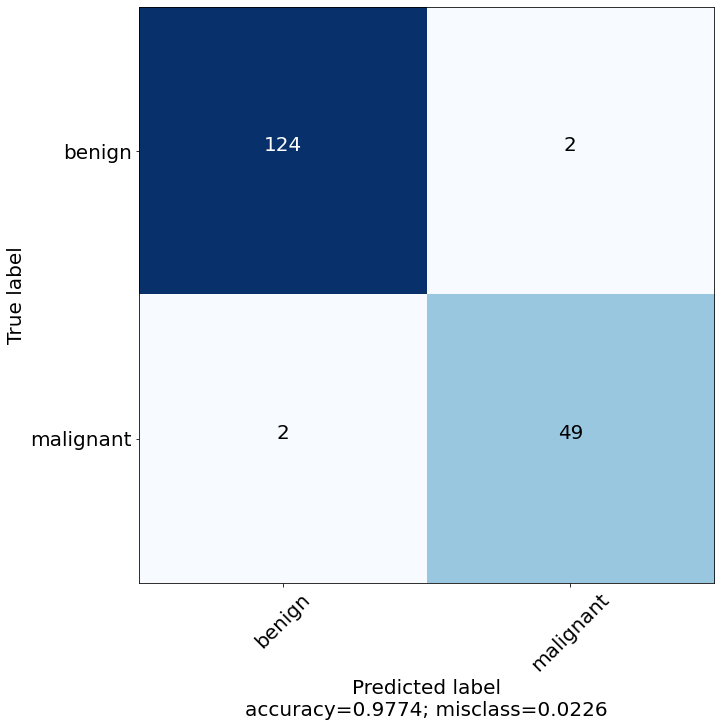

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[124   2]
 [  2  49]]
              precision    recall  f1-score   support

      benign       0.98      0.98      0.98       126
   malignant       0.96      0.96      0.96        51

    accuracy                           0.98       177
   macro avg       0.97      0.97      0.97       177
weighted avg       0.98      0.98      0.98       177



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  98.4126984126984
Specificity :  96.07843137254902


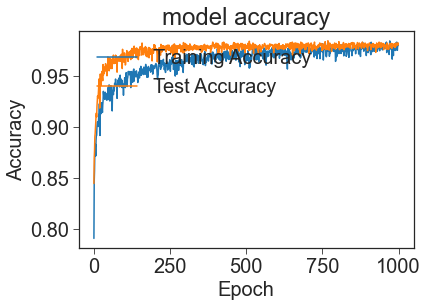

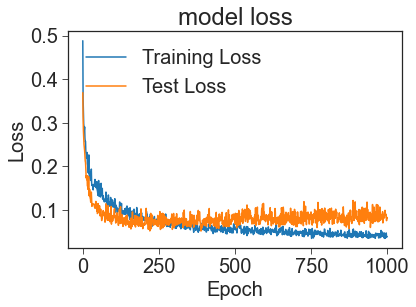

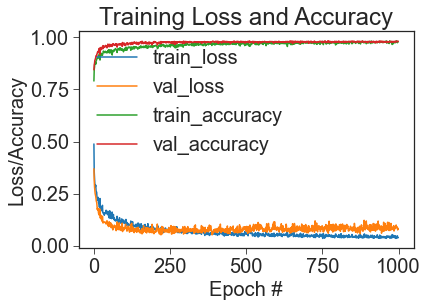

In [22]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")